In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils
import os
import matplotlib.pyplot as plt

from google.colab import files
import shutil

## Download and explore the dataset

In [2]:
# kukkakuva-aineisto, käytetään tunneilla.
# myöhemmin kun sinulla on oma aineisto Google Drivessä,
# aseta data_dir -muuttujan arvoksi oman kuvakansiosi polku (path)
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

print(data_dir)

228827136/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [3]:
# kuviin liittyvät parametrit
# yleensä vain IMAGE_SIZEä pitää muuttaa, jos neuroverkko tarvitsee
# tietyn kokoisia kuvia
# BATCH_SIZE on yleensä joko 32 tai 64, määrää sen minkäkokoisissa 
# osissa kuva syötetään neuroverkolle koulutusvaiheessa
IMAGE_SIZE = 224
BATCH_SIZE = 32
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)


# tehdään ImageDataGenerator neuroverkkoa varten
# kommentoidut parametrit liittyvät tiedon normalisointiin ja 
# data augmentointiin, käytä niitä harkiten!
# validation_split on tässä esimerkissä 20%, eli koulutukseen menee
# 80% kuvista, ja loput testiaineistoksi
datagen = keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255, 
    # shear_range = 0.1,
    # rotation_range=0.1,
    # zoom_range = 0.1,
    # horizontal_flip=True,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    validation_split=0.2)

# koulutusaineisto, shufflen on hyvä olla True, jotta neuroverkko saa
# satunnaisemmin kuvia eri kategorioista, yleensä parantaa lopputulosta
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    class_mode="sparse",
    subset='training')

# testaus/validointiaineisto
# TÄSSÄ ON TÄRKEÄÄ ETTÄ SHUFFLE ON FALSE
# muuten testiaineiston nimet ja kuvat menevät sekaisin, ja 
# malli oppii tunnistamaan kuvia miten sattuu
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=False,
    class_mode="sparse",
    subset='validation')


# tallennetaan kategorioiden nimet (eli kansionimet) talteen 
# myöhempää käyttöä varten (diagnostiikka ym.)
class_names = list(train_generator.class_indices.keys())
print(class_names)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [4]:
# VERSIO 1, ei data-augmentaatiota
# huomaa, ensimmäisessä layerissa pitää määritellä input_shape

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names))
])

# VERSIO 2, data-augmentaatio
# no transfer learning
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE,
                                  IMAGE_SIZE,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

# kytketään data-augmentaatio ja rescaling yhdeksi verkoksi
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names))
])

In [5]:
# esimerkki 1, erittäin simppeli kytkentä
model = tf.keras.Sequential([
  model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# esimerkki 2, 3x Dense-layer, 100 nodea per layer

#model = tf.keras.Sequential([
#  base_model,
#  tf.keras.layers.Flatten(),
#  tf.keras.layers.Dense(100, activation='relu'),
#  tf.keras.layers.Dense(100, activation='relu'),
#  tf.keras.layers.Dense(100, activation='relu'),
#  tf.keras.layers.Dense(len(class_names), activation='softmax')
#])

# esimerkki 3
#model = tf.keras.Sequential([
#  base_model,
#  tf.keras.layers.GlobalAveragePooling2D(),
#  tf.keras.layers.Dense(1024, activation='relu'),
#  tf.keras.layers.Dense(len(class_names), activation='softmax')
#])

# esimerkki 4
#model = tf.keras.Sequential([
#  base_model,
#  tf.keras.layers.Flatten(),
#  tf.keras.layers.BatchNormalization(),
#  tf.keras.layers.Dense(256, activation='relu'),
#  tf.keras.layers.Dropout(0.5),
#  tf.keras.layers.BatchNormalization(),
#  tf.keras.layers.Dense(128, activation='relu'),
#  tf.keras.layers.Dropout(0.5),
#  tf.keras.layers.BatchNormalization(),
#  tf.keras.layers.Dense(64, activation='relu'),
#  tf.keras.layers.Dropout(0.5),
#  tf.keras.layers.BatchNormalization(),
#  tf.keras.layers.Dense(len(class_names), activation='softmax')
#])

# esimerkki 5
#model = tf.keras.Sequential([
#  base_model,
#  tf.keras.layers.Conv2D(32, 3, activation='relu'),
#  tf.keras.layers.Dropout(0.2),
#  tf.keras.layers.GlobalAveragePooling2D(),
#  tf.keras.layers.Dense(len(class_names), activation='softmax')
#])

In [6]:
# asetetaan neuroverkon koulutuksen parametrit ennen koulutusta
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# tulostetaan yhteenveto mitä koko neuroverkko sisältää
# kätevä tarkistaa tätä kautta puuttuuko verkon kytkennästä jotain!
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 5)                 6446885   
_________________________________________________________________
flatten_2 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
Total params: 6,446,915
Trainable params: 6,446,915
Non-trainable params: 0
_________________________________________________________________


In [7]:
# asetetaan epochit ja pistetään neuroverkko kouluttamaan!
# jos oma neuroverkko, 25-50 on hyvä lähtökohta
# jos transfer learning, 10-20 on aluksi hyvä
epochs = 15

# tässä sitten vierähtää tovi, jos epocheja on paljon, neuroverkko on 
# monimutkainen ja/tai aineisto on suuri
history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


92/92 [==============================] - 47s 172ms/step - loss: 1.3993 - accuracy: 0.3661 - val_loss: 1.3368 - val_accuracy: 0.4651
Epoch 2/15
92/92 [==============================] - 18s 193ms/step - loss: 1.0773 - accuracy: 0.5713 - val_loss: 1.1845 - val_accuracy: 0.5472
Epoch 3/15
92/92 [==============================] - 15s 164ms/step - loss: 0.9791 - accuracy: 0.5985 - val_loss: 1.2902 - val_accuracy: 0.5486
Epoch 4/15
92/92 [==============================] - 15s 165ms/step - loss: 0.9048 - accuracy: 0.6458 - val_loss: 1.0573 - val_accuracy: 0.6265
Epoch 5/15
92/92 [==============================] - 15s 167ms/step - loss: 0.8612 - accuracy: 0.6659 - val_loss: 0.9797 - val_accuracy: 0.6238
Epoch 6/15
92/92 [==============================] - 15s 166ms/step - loss: 0.8120 - accuracy: 0.6924 - val_loss: 0.9810 - val_accuracy: 0.6512
Epoch 7/15
92/92 [==============================] - 15s 165ms/step - loss: 0.7819 - accuracy: 0.6979 - val_loss: 0.9593 - val_accuracy: 0.6443
Epoch 8/15

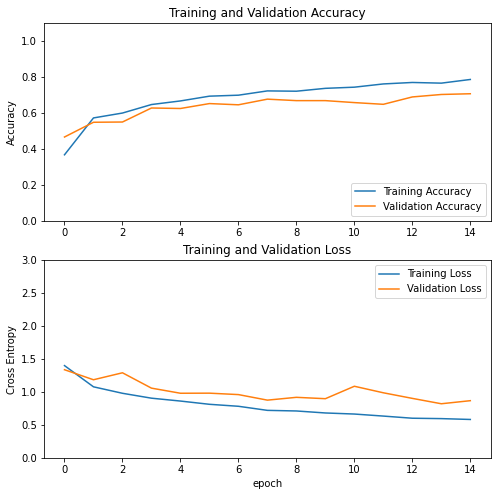

In [8]:
# visualisoidaan training_accuracy, training_loss, val_accuracy ja val_loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


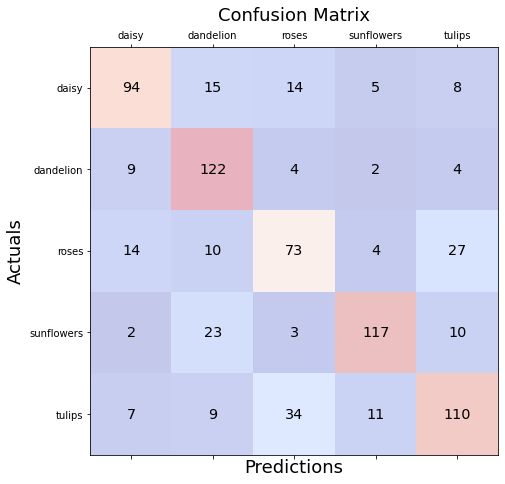


              precision    recall  f1-score   support

       daisy       0.69      0.75      0.72       126
   dandelion       0.87      0.68      0.76       179
       roses       0.57      0.57      0.57       128
  sunflowers       0.75      0.84      0.80       139
      tulips       0.64      0.69      0.67       159

    accuracy                           0.71       731
   macro avg       0.70      0.71      0.70       731
weighted avg       0.71      0.71      0.71       731


Model overall accuracy: 70.59%


In [9]:
# luodaan confusion matrix ja luokitteluraportti
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# jos käytät perinteisiä keras datasetejä, korvaa val_generator.samples arvolla
# len(val_generator.file_paths)
predictions = model.predict_generator(val_generator, val_generator.samples // BATCH_SIZE + 1)
y_pred = tf.argmax(predictions, axis=1)
true_categories = val_generator.classes
conf_matrix = confusion_matrix(y_pred, true_categories)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.coolwarm, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
 
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print()
print(classification_report(true_categories, y_pred, target_names=class_names))

acc = accuracy_score(true_categories, y_pred)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

In [11]:
# TESTATAAN MALLIA KANSIOLLISELLA KUVIA, nämä kuvat tulevat Drivestä
from PIL import Image, ImageOps
import numpy as np

from os import listdir
from os.path import isfile, join

from google.colab import drive
drive.mount("/content/drive") 

test_images = "/content/drive/MyDrive/Pilvilaskenta2021_Noora_Angelva/Pilvi4Kuva"

onlyfiles = [f for f in listdir(test_images) if isfile(join(test_images, f))]

print()

# käydään kaikki kuvat läpi
for f in onlyfiles:
  data = np.ndarray(shape=(1, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

  # haetaan yksittäinen kuva
  filename = test_images + "/" + f
  image = Image.open(filename)
  size = (IMAGE_SIZE, IMAGE_SIZE)
  image = ImageOps.fit(image, size, Image.ANTIALIAS)

  # esikäsittele kuva modelin mukaisesti
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
  
  # JOS rescale tehdäänkin imagegeneratorissa (eikä omassa neuroverkkolayerissa), 
  # silloin pitää normalisointi tehdä myös ennen syöttämistä testiin
  # data = np.ndarray(shape=(1, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
  # normalized_image_array = (img_array.astype(np.float32) *  1.0/255.0)
  # data[0] = normalized_image_array
  # img_batch = data[0]
  # huom, preprocessing jää pois, koska emme käytä olemassa olevaa mallia pohjana

  # syötetään kuva mallille
  prediction = model.predict(img_batch)

  # haetaan suurimman arvon indeksi tunnistamistuloksessa, sekä suurin arvo
  highest_index = prediction.argmax(axis=-1)[0]
  highest_value = prediction.max()
  
  print(f"Kuva: {f} - {class_names[highest_index]}, {round(highest_value * 100, 1)}%")

  # JOS OMAN NEUROVERKON VIIMEISEN LAYERIN ACTIVATION EI OLE SOFTMAX
  # jos käytät sparse_categorical_crossentropyä parametrilla from_logits=True, 
  # silloin ei käytetä softmaxia viimeisessä layerissa
  # jos from_logits=False, silloin voi viimeinen layer olla activation='softmax'
  # KUVA PITÄÄ TUNNISTAA SEN SIJAAN TÄLLÄ TAVALLA
  # img = tf.keras.utils.load_img(
  #   filename, target_size=size
  # )

  # img_array = tf.keras.utils.img_to_array(img)
  # img_array = tf.expand_dims(img_array, 0) 
  # predictions = model.predict(img_array)
  # score = tf.nn.softmax(predictions[0])

  # print(f"Kuva: {f} - {class_names[np.argmax(score)]}, {100 * np.max(score):.1f}%")

Mounted at /content/drive

Kuva: aarn-giri-3tYZjGSBwbk-unsplash.jpg - daisy, 50.5%
Kuva: olena-ivanova-uKVs2ovR0KY-unsplash.jpg - roses, 73.5%
Kuva: yoksel-zok-2qirUiysnbg-unsplash.jpg - tulips, 95.8%
